<a href="https://colab.research.google.com/github/gitgubbenito/capstone/blob/main/VAERS-v2.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Capstone Project - Vaccine Adverse Event Reporting System

Data files can be found at the following location:
https://vaers.hhs.gov/data/datasets.html

Datasets were to big to be uploaded to github

I focus on 2021 datasets

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#pip install chardet

In [ ]:
import chardet
with open('/content/drive/MyDrive/capstone/2021VAERSSYMPTOMS.csv', 'rb') as f:
    data = f.read()
    encoding_result = chardet.detect(data)
    encoding = encoding_result['encoding']
    print("Detected Encoding:", encoding)

Detected Encoding: ascii


#Things to do
- Load all 2021 files - done
- Explore Datasets - done
- Merge Datasets - done
- Data Clean-up - done
- Determine the most common sysmtoms by vaccine manu - Done
- How many people were disable o die due to the vaccine - Done
- Number of VAERS by state - Done
- Plot top 20 symtoms - Done
# Questions to be answer
1.  Do people who experience side effects from the vaccine tend to experience them sooner or later after vaccination?
2.  Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?
3.  Is there a noticeable difference in age between those who have no serious side effects and those who do?
4. What are the most common VAERS presented on pacients with COVID-19 vaccine






In [4]:
#Load all 2021 files
df_symptoms_2021 =pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSSYMPTOMS.csv')
df_vaers_data_2021 = pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSDATA.csv',encoding="Windows-1252")
df_vaers_vax_2021 = pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSVAX.csv',encoding="Windows-1252")


<ipython-input-4-8b19012f9fec>:3: DtypeWarning: Columns (7,12,15,23) have mixed types. Specify dtype option on import or set low_memory=False.
  df_vaers_data_2021 = pd.read_csv('/content/drive/MyDrive/capstone/2021VAERSDATA.csv',encoding="Windows-1252")


In [5]:
# Explore Datasets
print("Shape of df_symptoms_2021:", df_symptoms_2021.shape)
print("Shape of df_vaers_data_2021:", df_vaers_data_2021.shape)
print("Shape of df_vaers_vax_2021:", df_vaers_vax_2021.shape)


Shape of df_symptoms_2021: (1003896, 11)
Shape of df_vaers_data_2021: (753006, 35)
Shape of df_vaers_vax_2021: (797081, 8)


In [6]:
# Explore Datasets
df_vaers_vax_2021.isnull().sum()

VAERS_ID                0
VAX_TYPE                0
VAX_MANU                0
VAX_LOT            244925
VAX_DOSE_SERIES      4169
VAX_ROUTE          190149
VAX_SITE           220146
VAX_NAME                0
dtype: int64

In [7]:
# prompt: drop VAX_LOT ,  VAX_DOSE_SERIES, VAX_ROUTE , VAX_SITE

df_vaers_vax_2021.drop(columns=['VAX_LOT', 'VAX_DOSE_SERIES', 'VAX_ROUTE', 'VAX_SITE'], inplace=True)


In [8]:
df_vaers_vax_2021.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_NAME
0,910642,COVID19,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH))
1,916600,COVID19,MODERNA,COVID19 (COVID19 (MODERNA))
2,916601,COVID19,MODERNA,COVID19 (COVID19 (MODERNA))
3,916602,COVID19,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH))
4,916603,COVID19,MODERNA,COVID19 (COVID19 (MODERNA))


In [10]:
# prompt: drop V_FUNDBY, V_ADMINBY, OTHER_MEDS

df_vaers_data_2021.drop(columns=['V_FUNDBY', 'V_ADMINBY', 'OTHER_MEDS'], inplace=True)


In [11]:
# prompt: drop PRIOR_VAX, TODAYS_DATE, PRIOR_VAX ,CUR_ILL , LAB_DATA

df_vaers_data_2021.drop(columns=['PRIOR_VAX', 'TODAYS_DATE', 'PRIOR_VAX' ,'CUR_ILL' , 'LAB_DATA'], inplace=True)


In [12]:
# Explore Datasets
df_vaers_data_2021.isnull().sum()

VAERS_ID             0
RECVDATE             0
STATE           115887
AGE_YRS          81007
CAGE_YR         148654
CAGE_MO         748705
SEX                  0
RPT_DATE        752078
SYMPTOM_TEXT       577
DIED            742456
DATEDIED        743627
L_THREAT        741891
ER_VISIT        752879
HOSPITAL        705537
HOSPDAYS        721807
X_STAY          752628
DISABLE         741033
RECOVD           73431
VAX_DATE         55745
ONSET_DATE       65815
NUMDAYS          94529
HISTORY         378107
SPLTTYPE        533091
FORM_VERS            0
BIRTH_DEFECT    752547
OFC_VISIT       608478
ER_ED_VISIT     662703
ALLERGIES       454461
dtype: int64

In [13]:
df_vaers_data_2021.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,VAX_DATE,ONSET_DATE,NUMDAYS,HISTORY,SPLTTYPE,FORM_VERS,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,12/28/2020,12/30/2020,2.0,NaN,NaN,2,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,12/31/2020,12/31/2020,0.0,Patient residing at nursing facility. See pati...,NaN,2,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,12/31/2020,12/31/2020,0.0,NaN,NaN,2,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,12/23/2020,12/23/2020,0.0,"diverticulitis, mitral valve prolapse, osteoar...",NaN,2,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,12/22/2020,12/29/2020,7.0,NaN,NaN,2,NaN,NaN,NaN,Na


In [14]:
# Explore Datasets
df_symptoms_2021.isnull().sum()

VAERS_ID                0
SYMPTOM1                0
SYMPTOMVERSION1         0
SYMPTOM2           225538
SYMPTOMVERSION2    225538
SYMPTOM3           408255
SYMPTOMVERSION3    408255
SYMPTOM4           551438
SYMPTOMVERSION4    551438
SYMPTOM5           665894
SYMPTOMVERSION5    665894
dtype: int64

In [17]:
# Drop  Columns
clean_vaers_data_df = df_vaers_data_2021.drop(columns =['CAGE_YR', 'CAGE_MO', 'RPT_DATE', 'ONSET_DATE','NUMDAYS', 'LAB_DATA', 'SYMPTOM_TEXT',
                                                   'V_ADMINBY', 'DATEDIED', 'V_FUNDBY', 'OTHER_MEDS', 'CUR_ILL', 'PRIOR_VAX','VAX_DATE',
                                                   'SPLTTYPE', 'FORM_VERS', 'TODAYS_DATE', 'OFC_VISIT', 'HISTORY', 'ER_ED_VISIT', 'ALLERGIES',
                                                   'RECVDATE','STATE','HOSPDAYS','X_STAY','RECOVD'],errors='ignore')

In [18]:
clean_vaers_data_df.columns

Index(['VAERS_ID', 'AGE_YRS', 'SEX', 'DIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'DISABLE', 'BIRTH_DEFECT'],
      dtype='object')

**Note:** I will focus in column: SYMPTOM1

In [19]:
df_vaers_vax_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 797081 entries, 0 to 797080
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   VAERS_ID  797081 non-null  int64 
 1   VAX_TYPE  797081 non-null  object
 2   VAX_MANU  797081 non-null  object
 3   VAX_NAME  797081 non-null  object
dtypes: int64(1), object(3)
memory usage: 24.3+ MB


In [20]:
df_symptoms_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003896 entries, 0 to 1003895
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   VAERS_ID         1003896 non-null  int64  
 1   SYMPTOM1         1003896 non-null  object 
 2   SYMPTOMVERSION1  1003896 non-null  float64
 3   SYMPTOM2         778358 non-null   object 
 4   SYMPTOMVERSION2  778358 non-null   float64
 5   SYMPTOM3         595641 non-null   object 
 6   SYMPTOMVERSION3  595641 non-null   float64
 7   SYMPTOM4         452458 non-null   object 
 8   SYMPTOMVERSION4  452458 non-null   float64
 9   SYMPTOM5         338002 non-null   object 
 10  SYMPTOMVERSION5  338002 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 84.3+ MB


In [23]:
# prompt: drop SYMPTOMVERSION1. SYMPTOMVERSION2 , SYMPTOMVERSION3, SYMPTOMVERSION4, SYMPTOMVERSION5

df_symptoms_2021.drop(['SYMPTOMVERSION1', 'SYMPTOMVERSION2', 'SYMPTOMVERSION3', 'SYMPTOMVERSION4', 'SYMPTOMVERSION5'], axis=1, inplace=True,errors='ignore')


In [24]:
# prompt: how many vaers are by vacine manu

df_vaers_vax_2021['VAX_MANU'].value_counts()


VAX_MANU
MODERNA                              349254
PFIZER\BIONTECH                      328949
JANSSEN                               62327
UNKNOWN MANUFACTURER                  16709
GLAXOSMITHKLINE BIOLOGICALS           16291
MERCK & CO. INC.                      10490
SANOFI PASTEUR                         6888
SEQIRUS, INC.                          2155
NOVARTIS VACCINES AND DIAGNOSTICS      1474
PFIZER\WYETH                           1306
PROTEIN SCIENCES CORPORATION            535
DYNAVAX TECHNOLOGIES CORPORATION        247
EMERGENT BIOSOLUTIONS                   137
BERNA BIOTECH, LTD.                      97
MEDIMMUNE VACCINES, INC.                 68
TEVA PHARMACEUTICALS                     43
MASS. PUB HLTH BIOL LAB                  29
PAXVAX                                   25
MSP VACCINE COMPANY                      22
INTERCELL AG                             17
CSL LIMITED                               9
SMITHKLINE BEECHAM                        7
PASTEUR MERIEUX CONNAUG

In [25]:
# prompt: merge all 3 data frame

df_combine_2021 = pd.merge(df_vaers_data_2021, df_vaers_vax_2021, on='VAERS_ID', how='inner')
df_combine_2021 = pd.merge(df_combine_2021, df_symptoms_2021, on='VAERS_ID', how='inner')


In [26]:
df_combine_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070234 entries, 0 to 1070233
Data columns (total 36 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   VAERS_ID      1070234 non-null  int64  
 1   RECVDATE      1070234 non-null  object 
 2   STATE         923390 non-null   object 
 3   AGE_YRS       975545 non-null   float64
 4   CAGE_YR       881058 non-null   float64
 5   CAGE_MO       8245 non-null     float64
 6   SEX           1070234 non-null  object 
 7   RPT_DATE      1293 non-null     object 
 8   SYMPTOM_TEXT  1069604 non-null  object 
 9   DIED          20392 non-null    object 
 10  DATEDIED      18847 non-null    object 
 11  L_THREAT      26261 non-null    object 
 12  ER_VISIT      192 non-null      object 
 13  HOSPITAL      112784 non-null   object 
 14  HOSPDAYS      80015 non-null    float64
 15  X_STAY        771 non-null      object 
 16  DISABLE       27298 non-null    object 
 17  RECOVD        977511 non-nu

In [27]:
df_combine_2021.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_NAME,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,NaN,Pcn and bee venom,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dysphagia,Epiglottitis,NaN,NaN,NaN
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,NaN,"""Dairy""",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Anxiety,Dyspnoea,NaN,NaN,NaN
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,Y,Shellfish,COVID19,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dizziness,Fatigue,Mobility decreased,NaN,NaN
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,NaN,Na,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN


In [28]:
df_combine_2021.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'HISTORY', 'SPLTTYPE', 'FORM_VERS',
       'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES', 'VAX_TYPE',
       'VAX_MANU', 'VAX_NAME', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3', 'SYMPTOM4',
       'SYMPTOM5'],
      dtype='object')

In [29]:
# How many people die by vacine manu order by count

df_combine_2021.groupby('VAX_MANU')['DIED'].value_counts().sort_values(ascending=False)


VAX_MANU                           DIED
PFIZER\BIONTECH                    Y       9646
MODERNA                            Y       8160
JANSSEN                            Y       1901
UNKNOWN MANUFACTURER               Y        374
MERCK & CO. INC.                   Y         92
GLAXOSMITHKLINE BIOLOGICALS        Y         78
SANOFI PASTEUR                     Y         77
PFIZER\WYETH                       Y         39
SEQIRUS, INC.                      Y         14
PROTEIN SCIENCES CORPORATION       Y          4
NOVARTIS VACCINES AND DIAGNOSTICS  Y          3
DYNAVAX TECHNOLOGIES CORPORATION   Y          2
PAXVAX                             Y          2
Name: count, dtype: int64

In [31]:
# prompt: how many rows and columns are there for each df

print("df_symptoms_2021 has", df_symptoms_2021.shape[0], "rows and", df_symptoms_2021.shape[1], "columns")
print("df_vaers_data_2021 has", df_vaers_data_2021.shape[0], "rows and", df_vaers_data_2021.shape[1], "columns")
print("df_vaers_vax_2021 has", df_vaers_vax_2021.shape[0], "rows and", df_vaers_vax_2021.shape[1], "columns")


df_symptoms_2021 has 1003896 rows and 6 columns
df_vaers_data_2021 has 753006 rows and 28 columns
df_vaers_vax_2021 has 797081 rows and 4 columns


In [32]:
df_combine_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070234 entries, 0 to 1070233
Data columns (total 36 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   VAERS_ID      1070234 non-null  int64  
 1   RECVDATE      1070234 non-null  object 
 2   STATE         923390 non-null   object 
 3   AGE_YRS       975545 non-null   float64
 4   CAGE_YR       881058 non-null   float64
 5   CAGE_MO       8245 non-null     float64
 6   SEX           1070234 non-null  object 
 7   RPT_DATE      1293 non-null     object 
 8   SYMPTOM_TEXT  1069604 non-null  object 
 9   DIED          20392 non-null    object 
 10  DATEDIED      18847 non-null    object 
 11  L_THREAT      26261 non-null    object 
 12  ER_VISIT      192 non-null      object 
 13  HOSPITAL      112784 non-null   object 
 14  HOSPDAYS      80015 non-null    float64
 15  X_STAY        771 non-null      object 
 16  DISABLE       27298 non-null    object 
 17  RECOVD        977511 non-nu

In [33]:
df_combine_2021.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_NAME,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,NaN,Pcn and bee venom,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dysphagia,Epiglottitis,NaN,NaN,NaN
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,NaN,"""Dairy""",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Anxiety,Dyspnoea,NaN,NaN,NaN
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,Y,Shellfish,COVID19,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dizziness,Fatigue,Mobility decreased,NaN,NaN
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,NaN,Na,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN


In [34]:
df_combine_2021.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070234 entries, 0 to 1070233
Data columns (total 36 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   VAERS_ID      1070234 non-null  int64  
 1   RECVDATE      1070234 non-null  object 
 2   STATE         923390 non-null   object 
 3   AGE_YRS       975545 non-null   float64
 4   CAGE_YR       881058 non-null   float64
 5   CAGE_MO       8245 non-null     float64
 6   SEX           1070234 non-null  object 
 7   RPT_DATE      1293 non-null     object 
 8   SYMPTOM_TEXT  1069604 non-null  object 
 9   DIED          20392 non-null    object 
 10  DATEDIED      18847 non-null    object 
 11  L_THREAT      26261 non-null    object 
 12  ER_VISIT      192 non-null      object 
 13  HOSPITAL      112784 non-null   object 
 14  HOSPDAYS      80015 non-null    float64
 15  X_STAY        771 non-null      object 
 16  DISABLE       27298 non-null    object 
 17  RECOVD        977511 non-nu

In [35]:
# prompt: Determine the top 12 most common sysmtoms by vaccine manu

top_12_symptoms = df_combine_2021.groupby('VAX_MANU')['SYMPTOM1'].value_counts().sort_values(ascending=False).head(12)
print(top_12_symptoms)


VAX_MANU         SYMPTOM1               
MODERNA          Chills                     28733
                 Arthralgia                 20233
PFIZER\BIONTECH  Chills                     19162
                 Arthralgia                 17683
                 COVID-19                   17323
                 Dizziness                  16167
MODERNA          Injection site erythema    14783
                 Fatigue                    13872
                 Headache                   12506
PFIZER\BIONTECH  Fatigue                    11969
MODERNA          Dizziness                  11868
PFIZER\BIONTECH  Headache                   10987
Name: count, dtype: int64


In [36]:
# prompt: systoms for people who die value counts

df_combine_2021.groupby('DIED')['SYMPTOM1'].value_counts()


DIED  SYMPTOM1                      
Y     Death                             4508
      COVID-19                          1881
      Acute respiratory failure          460
      Asthenia                           448
      Acute kidney injury                439
                                        ... 
      Mean cell volume                     1
      Bronchiectasis                       1
      Mean platelet volume increased       1
      Bronchial disorder                   1
      Hepatic lesion                       1
Name: count, Length: 1689, dtype: int64

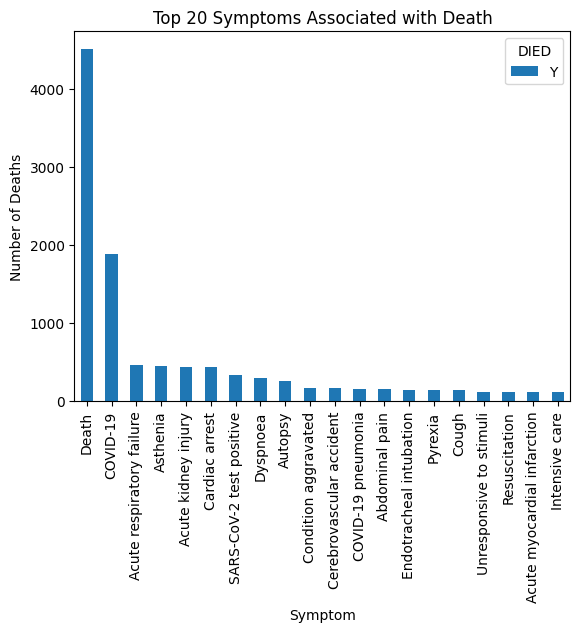

In [37]:
# prompt: plot the most common systom1 who DIED top 20

import matplotlib.pyplot as plt

# Group the data by SYMPTOM1 and DIED
grouped_data = df_combine_2021.groupby(['SYMPTOM1', 'DIED'])['VAERS_ID'].count().unstack()

# Sort the data by the number of deaths
grouped_data = grouped_data.sort_values(by='Y', ascending=False)

# Select the top 20 symptoms
top_20_symptoms = grouped_data.head(20)

# Plot the data as a bar chart
top_20_symptoms.plot(kind='bar', stacked=True)
plt.xlabel('Symptom')
plt.ylabel('Number of Deaths')
plt.title('Top 20 Symptoms Associated with Death')
plt.show()


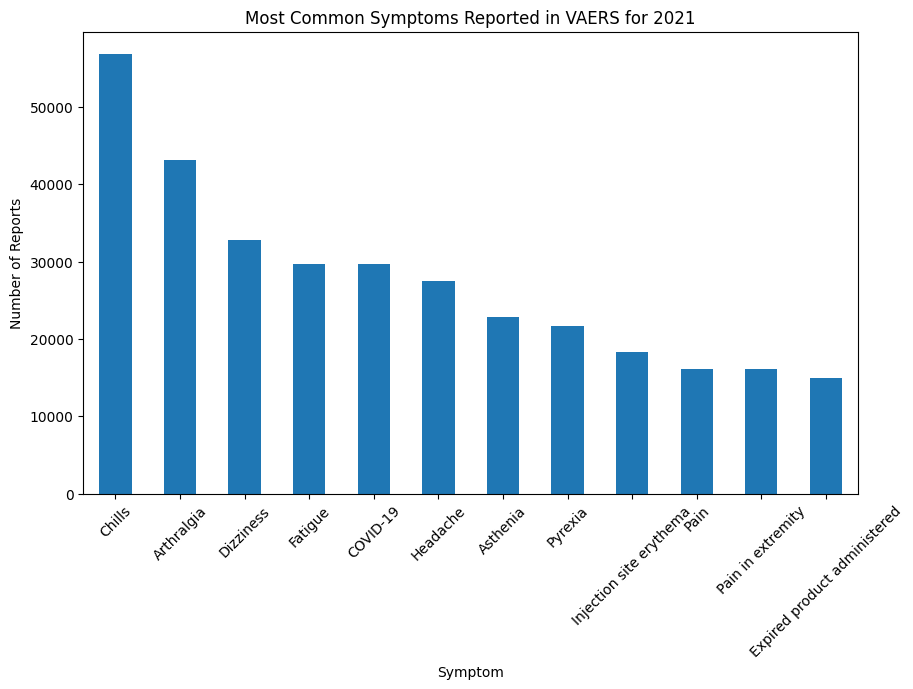

In [38]:
# prompt: plot the most common systom1 and plot it

import matplotlib.pyplot as plt

# Get the top 12 symptoms
top_12_symptoms = df_combine_2021.groupby('SYMPTOM1')['VAERS_ID'].count().sort_values(ascending=False).head(12)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_12_symptoms.plot(kind='bar')

# Add title and labels
plt.title('Most Common Symptoms Reported in VAERS for 2021')
plt.xlabel('Symptom')
plt.ylabel('Number of Reports')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [39]:
# prompt: how many people die by vacine manu

#df_combine_2021.groupby('VAX_MANU')['DIED'].sum()
df_combine_2021.groupby('VAX_MANU')['DIED'].value_counts()


VAX_MANU                           DIED
DYNAVAX TECHNOLOGIES CORPORATION   Y          2
GLAXOSMITHKLINE BIOLOGICALS        Y         78
JANSSEN                            Y       1901
MERCK & CO. INC.                   Y         92
MODERNA                            Y       8160
NOVARTIS VACCINES AND DIAGNOSTICS  Y          3
PAXVAX                             Y          2
PFIZER\BIONTECH                    Y       9646
PFIZER\WYETH                       Y         39
PROTEIN SCIENCES CORPORATION       Y          4
SANOFI PASTEUR                     Y         77
SEQIRUS, INC.                      Y         14
UNKNOWN MANUFACTURER               Y        374
Name: count, dtype: int64

In [40]:
# prompt: set the index as VAERS_ID

df_symptoms = df_combine_2021.set_index('VAERS_ID')


In [41]:
df_symptoms.head(10)

,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,DATEDIED,...,ER_ED_VISIT,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_NAME,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,NaN,...,NaN,Pcn and bee venom,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dysphagia,Epiglottitis,NaN,NaN,NaN
916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,NaN,...,NaN,"""Dairy""",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Anxiety,Dyspnoea,NaN,NaN,NaN
916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,NaN,...,Y,Shellfish,COVID19,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN
916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,NaN,...,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dizziness,Fatigue,Mobility decreased,NaN,NaN
916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,NaN,...,NaN,Na,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN
916605,01/01/2021,TX,40.0,40.0,NaN,M,NaN,"Adverse Events: Inflammation in the eye, confu...",NaN,NaN,...,NaN,NaN,FLUC4,"SEQIRUS, INC.",INFLUENZA (SEASONAL) (FLUCELVAX QUADRIVALENT),Chills,Confusional state,Eye inflammation,Headache,Laboratory test
916605,01/01/2021,TX,40.0,40.0,NaN,M,NaN,"Adverse Events: Inflammation in the eye, confu...",NaN,NaN,...,NaN,NaN,FLUC4,"SEQIRUS, INC.",INFLUENZA (SEASONAL) (FLUCELVAX QUADRIVALENT),Pyrexia,White blood cell count decreased,NaN,NaN,NaN
916606,01/01/2021,NV,44.0,44.0,NaN,F,NaN,patient called back the next day and stated he...,NaN,NaN,...,NaN,iodine (shellfish) has epipen,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Pharyngeal swelling,NaN,NaN,NaN,NaN
916607,01/01/2021,KS,50.0,50.0,NaN,M,NaN,SEVERE chills approximately 13-14 hours after ...,NaN,NaN,...,NaN,Penicillin,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Abdominal pain,Chills,Sleep disorder,NaN,NaN


In [42]:
# prompt: what are the values of DIED

df_combine_2021['DIED'].value_counts()


DIED
Y    20392
Name: count, dtype: int64

In [44]:
# prompt: How many people die by state

df_combine_2021.groupby('STATE')['DIED'].value_counts().sort_values(ascending=False)


STATE  DIED
TX     Y       1436
MI     Y       1378
KY     Y       1361
CA     Y       1084
FL     Y        906
NY     Y        668
TN     Y        620
IL     Y        570
GA     Y        561
MN     Y        535
WI     Y        521
PA     Y        480
OH     Y        478
WA     Y        448
MO     Y        388
NJ     Y        308
MA     Y        264
NC     Y        260
IN     Y        240
VA     Y        227
AZ     Y        212
CO     Y        198
IA     Y        198
MD     Y        188
AR     Y        175
SC     Y        165
PR     Y        161
OR     Y        157
NH     Y        145
KS     Y        137
SD     Y        136
AL     Y        131
NE     Y        130
LA     Y        125
MT     Y        124
NM     Y        109
OK     Y         93
CT     Y         90
MS     Y         87
WV     Y         85
ND     Y         75
ME     Y         69
NV     Y         58
UT     Y         54
HI     Y         51
WY     Y         46
AK     Y         39
ID     Y         36
DE     Y         35
VT     Y

In [44]:
# prompt: combine all columns into one SYMPTOM

df_combine_2021['SYMPTOM'] = df_combine_2021['SYMPTOM1'].fillna('') + ',' + df_combine_2021['SYMPTOM2'].fillna('') + ',' + df_combine_2021['SYMPTOM3'].fillna('')


In [45]:
# prompt: top 12 value counts for sysmtoms

df_symptoms['SYMPTOM1' ].value_counts().head(12)



SYMPTOM1
Chills                          56844
Arthralgia                      43081
Dizziness                       32838
Fatigue                         29682
COVID-19                        29674
Headache                        27503
Asthenia                        22798
Pyrexia                         21639
Injection site erythema         18272
Pain                            16171
Pain in extremity               16082
Expired product administered    15008
Name: count, dtype: int64

In [46]:
# prompt: append SYMPTOM1, SYMPTOM2

df_combine_2021['SYMPTOM'] = df_combine_2021['SYMPTOM1'].fillna('') + ',' + df_combine_2021['SYMPTOM2'].fillna('')
df_combine_2021.head()


,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,ALLERGIES,VAX_TYPE,VAX_MANU,VAX_NAME,SYMPTOM1,SYMPTOM2,SYMPTOM3,SYMPTOM4,SYMPTOM5,SYMPTOM
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,Pcn and bee venom,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dysphagia,Epiglottitis,NaN,NaN,NaN,"Dysphagia,Epiglottitis"
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,"""Dairy""",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Anxiety,Dyspnoea,NaN,NaN,NaN,"Anxiety,Dyspnoea"
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,Shellfish,COVID19,PFIZER\BIONTECH,COVID19 (COVID19 (PFIZER-BIONTECH)),Chest discomfort,Dysphagia,Pain in extremity,Visual impairment,NaN,"Chest discomfort,Dysphagia"
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,"Diclofenac, novacaine, lidocaine, pickles, tom...",COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Dizziness,Fatigue,Mobility decreased,NaN,NaN,"Dizziness,Fatigue"
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,Na,COVID19,MODERNA,COVID19 (COVID19 (MODERNA)),Injection site erythema,Injection site pruritus,Injection site swelling,Injection site warmth,NaN,"Injection site erythema,Injection site pruritus"


In [ ]:
# prompt: WHAT ARE TOP 10 MOST COMMON VALUE IN SYMPTOM1
df_symptoms['SYMPTOM2'].value_counts().head(12)


SYMPTOM2
Headache                    40192
Fatigue                     37086
Chills                      29014
Pyrexia                     21791
Dizziness                   20991
Pain                        20446
Pain in extremity           16983
Nausea                      15718
SARS-CoV-2 test positive    13644
Injection site pain         13000
Dyspnoea                    12512
Myalgia                     11566
Name: count, dtype: int64

In [47]:
df_symptoms.columns

Index(['RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'RPT_DATE',
       'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL',
       'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE', 'ONSET_DATE',
       'NUMDAYS', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'HISTORY', 'SPLTTYPE',
       'FORM_VERS', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES',
       'VAX_TYPE', 'VAX_MANU', 'VAX_NAME', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3',
       'SYMPTOM4', 'SYMPTOM5'],
      dtype='object')

In [48]:
# prompt: combine SYMPTOM1,SYMPTOM2 in one column

df_symptoms['SYMPTOMS'] = df_symptoms['SYMPTOM1'].fillna('') + ',' + df_symptoms['SYMPTOM2'].fillna('')


In [49]:
# prompt: append SYMPTOM1 and SYMPTOM2 but in rows

df_combine_2021['SYMPTOMS'] = df_combine_2021[['SYMPTOM1', 'SYMPTOM2']].apply(lambda x: ', '.join(x.dropna()), axis=1)


In [ ]:
# prompt: show to 20 rows SYMPTOMS

df_combine_2021['SYMPTOMS'].head(20)


0                               Dysphagia, Epiglottitis
1                                     Anxiety, Dyspnoea
2                           Chest discomfort, Dysphagia
3                                    Dizziness, Fatigue
4      Injection site erythema, Injection site pruritus
5                             Chills, Confusional state
6             Pyrexia, White blood cell count decreased
7                                   Pharyngeal swelling
8                                Abdominal pain, Chills
9                           Diarrhoea, Nasal congestion
10    Vaccination site erythema, Vaccination site pr...
11                                      Rash, Urticaria
12                 Blood pressure decreased, Chest pain
13                                    Dyspnoea, Fatigue
14           Heart rate decreased, Heart rate increased
15                                         Nausea, Pain
16    SARS-CoV-2 antibody test, SARS-CoV-2 test nega...
17                              Ear pain, Hypoae

In [50]:
print(df_symptoms.columns)



Index(['RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX', 'RPT_DATE',
       'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT', 'HOSPITAL',
       'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE', 'ONSET_DATE',
       'NUMDAYS', 'V_ADMINBY', 'V_FUNDBY', 'OTHER_MEDS', 'HISTORY', 'SPLTTYPE',
       'FORM_VERS', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT', 'ALLERGIES',
       'VAX_TYPE', 'VAX_MANU', 'VAX_NAME', 'SYMPTOM1', 'SYMPTOM2', 'SYMPTOM3',
       'SYMPTOM4', 'SYMPTOM5', 'SYMPTOMS'],
      dtype='object')


In [51]:
df_symptoms.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1070234 entries, 916600 to 2594447
Data columns (total 39 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   RECVDATE      1070234 non-null  object 
 1   STATE         923390 non-null   object 
 2   AGE_YRS       975545 non-null   float64
 3   CAGE_YR       881058 non-null   float64
 4   CAGE_MO       8245 non-null     float64
 5   SEX           1070234 non-null  object 
 6   RPT_DATE      1293 non-null     object 
 7   SYMPTOM_TEXT  1069604 non-null  object 
 8   DIED          20392 non-null    object 
 9   DATEDIED      18847 non-null    object 
 10  L_THREAT      26261 non-null    object 
 11  ER_VISIT      192 non-null      object 
 12  HOSPITAL      112784 non-null   object 
 13  HOSPDAYS      80015 non-null    float64
 14  X_STAY        771 non-null      object 
 15  DISABLE       27298 non-null    object 
 16  RECOVD        977511 non-null   object 
 17  VAX_DATE      1003370 non-n

In [52]:
# prompt: count  VAX_TYPE and print by value type

df_combine_2021['VAX_TYPE'].value_counts()


VAX_TYPE
COVID19    1003682
VARZOS       16956
UNK          12246
FLU4          6789
HPV9          2161
            ...   
MU               1
MNQHIB           1
PNC10            1
DTPHEP           1
H5N1             1
Name: count, Length: 70, dtype: int64

In [ ]:
# prompt: keep all row where VAX_TYPE is COVID19

df_combine_2021 = df_combine_2021[df_combine_2021['VAX_TYPE'] == 'COVID19']


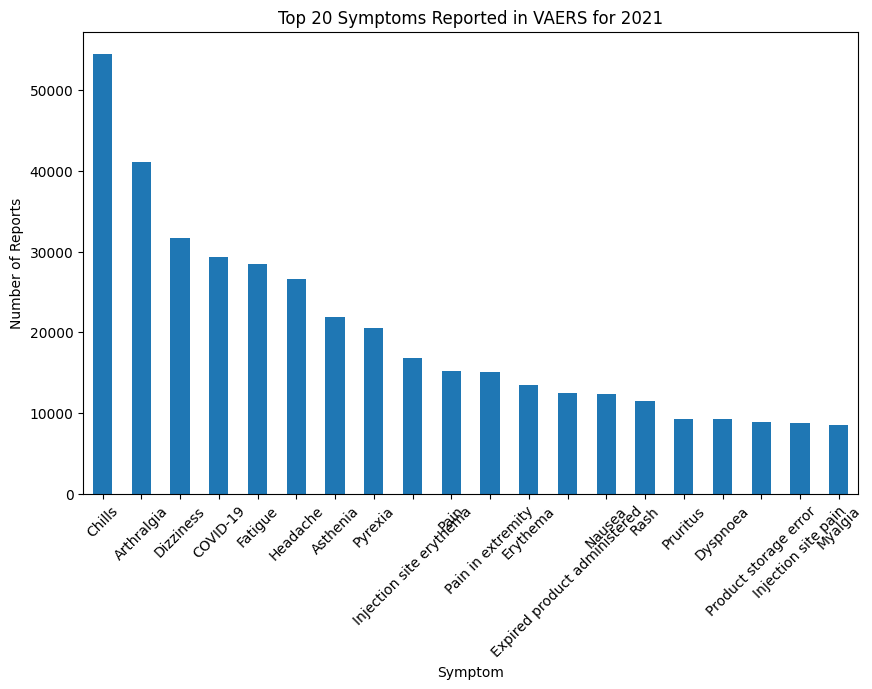

In [ ]:
# prompt: plot symtoms1 top 20

import pandas as pd
import matplotlib.pyplot as plt

# Get the top 20 symptoms
top_20_symptoms = df_combine_2021['SYMPTOM1'].value_counts().head(20)

# Create a bar chart
plt.figure(figsize=(10, 6))
top_20_symptoms.plot(kind='bar')

# Add title and labels
plt.title('Top 20 Symptoms Reported in VAERS for 2021')
plt.xlabel('Symptom')
plt.ylabel('Number of Reports')

# Rotate x-axis labels for readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [ ]:
# prompt: how many people DIED by sex

died_by_sex = df_combine_2021.groupby('SEX')['DIED'].value_counts()
print(died_by_sex)


SEX  DIED
F    Y        8105
M    Y       11743
U    Y         544
Name: count, dtype: int64


In [ ]:
# prompt: count SYMPTOM1

countSymtoms1=df_combine_2021['SYMPTOM1'].value_counts().head(20)
print(countSymtoms1)


SYMPTOM1
Chills                          56844
Arthralgia                      43081
Dizziness                       32838
Fatigue                         29682
COVID-19                        29674
Headache                        27503
Asthenia                        22798
Pyrexia                         21639
Injection site erythema         18272
Pain                            16171
Pain in extremity               16082
Expired product administered    15008
Erythema                        14820
Nausea                          12754
Rash                            12361
Product storage error           10783
Pruritus                         9637
Dyspnoea                         9551
Injection site pain              9412
No adverse event                 8922
Name: count, dtype: int64


In [ ]:
# prompt: what us the most common symtom vaccine manu

most_common_symptom = df_combine_2021['SYMPTOM1'].mode()[0]
print(f"The most common symptom is: {most_common_symptom}")


The most common symptom is: Chills


In [ ]:
# prompt: count symtom by state for top 5 state with symtoms

top_5_states = df_combine_2021['STATE'].value_counts().head(5).index.tolist()

symptom_counts_by_state = {}

for state in top_5_states:
  state_symptoms = df_combine_2021[df_combine_2021['STATE'] == state]['SYMPTOM1'].value_counts()
  symptom_counts_by_state[state] = state_symptoms

for state, symptoms in symptom_counts_by_state.items():
  print(f"Top symptoms in {state}:")
  print(symptoms.head())
  print()


Top symptoms in CA:
SYMPTOM1
Chills        4423
Dizziness     4092
Arthralgia    3461
Fatigue       2417
Headache      2279
Name: count, dtype: int64

Top symptoms in FL:
SYMPTOM1
Chills        2921
Arthralgia    2585
Dizziness     1897
Asthenia      1600
Fatigue       1565
Name: count, dtype: int64

Top symptoms in TX:
SYMPTOM1
Chills                          2715
Arthralgia                      2142
Dizziness                       1865
Expired product administered    1537
Headache                        1453
Name: count, dtype: int64

Top symptoms in NY:
SYMPTOM1
Chills                   2791
Arthralgia               2063
Dizziness                1671
Fatigue                  1517
Product storage error    1456
Name: count, dtype: int64

Top symptoms in MI:
SYMPTOM1
COVID-19      2250
Chills        1506
Arthralgia    1168
Asthenia       976
Dizziness      862
Name: count, dtype: int64



In [ ]:
# prompt: number of VAERS by state

df_combine_2021['STATE'].value_counts()


STATE
CA    98874
FL    59533
TX    57786
NY    54989
MI    38766
      ...  
Tx        5
XV        4
Ca        2
Co        2
QM        2
Name: count, Length: 65, dtype: int64

In [45]:
# prompt: how many null values are the dataset df_vaers_vax_2021

df_vaers_vax_2021.isnull().sum()


VAERS_ID    0
VAX_TYPE    0
VAX_MANU    0
VAX_NAME    0
dtype: int64

Number of VAERS by state

In [47]:
# prompt: prompt: convert columns ONSET_DATE, VAX_DATE into datetime include ignore error in df_combine_2021

import pandas as pd
df_combine_2021['ONSET_DATE'] = pd.to_datetime(df_combine_2021['ONSET_DATE'], errors='ignore')
df_combine_2021['VAX_DATE'] = pd.to_datetime(df_combine_2021['VAX_DATE'], errors='ignore')


In [48]:
# prompt: convert columns ONSET_DATE, VAX_DATE into datetime

import pandas as pd
#df_vaers_vax_2021['ONSET_DATE'] = pd.to_datetime(df_vaers_vax_2021['ONSET_DATE'])
#df_vaers_vax_2021['VAX_DATE'] = pd.to_datetime(df_vaers_vax_2021['VAX_DATE'])

# Replace 'unknown manufacturer' with NaN.
df_combine_2021['VAX_MANU'] = df_combine_2021['VAX_MANU'].replace('UNKNOWN MANUFACTURER', np.nan, regex=True)

# Remove Na value rows from vax manufacturer column and overwrite covid_df2.
df_combine_2021 = df_combine_2021.dropna(subset = ['VAX_MANU'])

# Check how many rows of data now
print(df_combine_2021['VAERS_ID'].nunique())
df_combine_2021.reset_index(inplace=True)


740442


In [73]:
# prompt: Can factors like age, gender, vaccine brand, and medical conditions help predict how strongly someone might react to the vaccine?

import pandas as pd

# Read the data into a DataFrame

df=df_combine_2021.copy()

# Select the relevant columns
df = df[['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']]

# Group the data by age, sex, vaccine brand, and death
grouped_data = df.groupby(['AGE_YRS', 'SEX', 'VAX_MANU', 'DIED']).size().unstack()

# Calculate the percentage of people who died for each group
grouped_data = grouped_data.apply(lambda x: x / x.sum() * 100, axis=1)

# Print the results
print(grouped_data)


DIED                                         Y
AGE_YRS SEX VAX_MANU                          
0.08    F   GLAXOSMITHKLINE BIOLOGICALS  100.0
        M   MERCK & CO. INC.             100.0
0.17    F   GLAXOSMITHKLINE BIOLOGICALS  100.0
            PFIZER\WYETH                 100.0
            SANOFI PASTEUR               100.0
...                                        ...
103.00  M   MODERNA                      100.0
104.00  F   PFIZER\BIONTECH              100.0
            MODERNA                      100.0
105.00  F   PFIZER\BIONTECH              100.0
106.00  F   MODERNA                      100.0

[676 rows x 1 columns]
